#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 4: Detección de Anomalías  </center>

# Introducción

En la siguiente actividad se trabajará en la detección de anomalías sobre redes de computadoras a partir de datos de tráfico. El objetivo será construir un modelo capaz de distinguir entre malas conexiones o ataques, y buenas conexiones, llamadas normales. Para esto se utilizará una parte del conjunto [KDD Cup'99](https://scikit-learn.org/stable/datasets/real_world.html#kddcup99-dataset) pensada para evaluar métodos de detección de anomalías. 

Para los problemas de detección de anomalías generalmente no se cuenta con datos etiquetados para entrenar un detector. Por su definición las anomalías son eventos raros y por lo tanto poco frecuentes, lo que dificulta el etiquetado. Es por esto que este tipo de tareas generalmente son no supervisadas.

El enfoque más habitual para implementar soluciones para este tipo de problemas, es crear un modelo base a partir de un conjunto de datos "normales", es decir de los cuales se tenga cierta certeza de que todos fueron adquiridos en una situación normal. Luego, en producción se detectarán como datos anómalos todos aquellos que no se ajusten a este modelo. Para saber el grado de ajuste de los datos se debe seleccionar un punto de operación, es decir, determinar cuándo un dato se considera anómalo. En un ejemplo real, el cliente primero debería proporcionar una cantidad considerable de datos que representen el comportamiento normal de su sistema. Luego que se tiene el mejor modelo posible de estos datos, junto con el cliente, que es el que conoce su sistema, se debe determinar el punto de operación a partir del compromiso entre detectar la mayor cantidad de anomalías y obtener la menor cantidad de falsas alarmas posibles.

Para hacer investigación en la detección de anomalías, existen conjuntos de datos como el que se trabajará en esta actividad que si tienen etiquetas. Generalmente estas se obtienen provocando fallas y/o ataques intencionales a un sistema que se encuentra funcionando de manera normal. En esta actividad se separará el conjunto de entrenamiento en dos partes. La primera con una gran proporción de datos etiquetados como normales, simulará ser el conjunto que el cliente nos proporciona para entrenar nuestro modelo. El otro conjunto tendrá datos etiquetados como normales y como anómalos, que se utilizará para definir el punto de operación. Asimismo, se tendrá un conjunto de test asociados a este problema para evaluar la puesta en producción del modelo. 

## Objetivos


*   Abordar un problema de detección de anomalías, y ver las diferencias con un problema de clasificación convencional.
*   Trabajar con algoritmos de aprendizaje no supervisado.
*   Crear detectores compatibles con los *pipelines* de *scikit-learn*.


# Formas de trabajo

### Opción 1: Trabajar localmente

# Descargar los datos en su máquina personal y trabajar en su propio ambiente de desarrollo.

`conda activate TAA-py311`              
`jupyter-notebook`    

Los paquetes faltantes se pueden instalar desde el notebook haciendo:     
` !pip install paquete_faltante` 

### Opción 2:  Trabajar en *Colab*. 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2024/blob/main/talleres/taller4_anomalias.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`. 

# Datos

### Parte 1 - Levantar los Datos

#### Conjunto de Entrenamiento

El conjunto de datos [KDD Cup'99](https://scikit-learn.org/stable/datasets/real_world.html#kddcup99-dataset) contiene un conjunto de datos de tráfico de red que incluye tráfico normal y malicioso. El conjunto de datos para entrenamiento contiene 100655 instancias donde cada una cuenta con 41 características entre las que se encuentran la duración de la conexión, los tipos de protocolo, los tipos de servicios, entre otros. Por más información sobre el contenido de las características haga clic [aquí](http://kdd.ics.uci.edu/databases/kddcup99/task.html). Además, se cuenta con la columna *'labels'* que indica si el dato es normal o, de no serlo, indica el tipo de anomalía.

#### Ejercicios:

 - Ejecute la siguientes celdas para levantar el conjunto de datos de entrenamiento. 
 - Observar la cantidad de muestras por tipo. 
 - Determinar la relación entre datos normales y anómalos.  

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.datasets import fetch_kddcup99

#Se obtienen los datos en formato de diccionario
KDDSA = fetch_kddcup99(subset='SA', as_frame=True, random_state=42)

#A partir del diccionario se crea un Dataframe con los datos
df = pd.DataFrame(data=KDDSA.frame.values, columns=KDDSA.frame.columns)

#Se estandariza el formato de los datos en el Dataframe 
types = [float, str, str,str, float, float, str, float, float, float, float, str, float, float,float, float, float, float, float, float, str, str, 
         float, float, float, float,float, float, float, float,float, float, float, float, float, float, float,float, float, float, float, str]

columns = df.columns
for i in range(len(columns)):
    df[columns[i]] = df[columns[i]].astype(types[i])
    if types[i] == str:
        df[columns[i]]= df[columns[i]].str.replace("b'", "")
        df[columns[i]]= df[columns[i]].str.replace("'", "")

#Visualizo
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0.0,tcp,http,SF,181.0,5450.0,0,0.0,0.0,0.0,...,9.0,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0.0,tcp,http,SF,239.0,486.0,0,0.0,0.0,0.0,...,19.0,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0.0,tcp,http,SF,235.0,1337.0,0,0.0,0.0,0.0,...,29.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0.0,tcp,http,SF,219.0,1337.0,0,0.0,0.0,0.0,...,39.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0.0,tcp,http,SF,217.0,2032.0,0,0.0,0.0,0.0,...,49.0,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [2]:
cant_tcp = (df['protocol_type'] == 'tcp')


cant_interes = df.loc[( df['labels']=='normal.') & (df['protocol_type'] == 'tcp')] 
cant_interes2 = df.loc[( df['labels']=='normal.') & (df['protocol_type'] == 'udp')] 
print(len(df['labels']=='normal.'))

print(len(cant_interes))
print(len(cant_interes2))

100655
76813
19177


In [3]:
df.info

<bound method DataFrame.info of         duration protocol_type  service flag  src_bytes  dst_bytes land  \
0            0.0           tcp     http   SF      181.0     5450.0    0   
1            0.0           tcp     http   SF      239.0      486.0    0   
2            0.0           tcp     http   SF      235.0     1337.0    0   
3            0.0           tcp     http   SF      219.0     1337.0    0   
4            0.0           tcp     http   SF      217.0     2032.0    0   
...          ...           ...      ...  ...        ...        ...  ...   
100650       0.0          icmp    ecr_i   SF     1032.0        0.0    0   
100651       0.0          icmp    ecr_i   SF      520.0        0.0    0   
100652       0.0          icmp    ecr_i   SF     1032.0        0.0    0   
100653       0.0          icmp    ecr_i   SF      520.0        0.0    0   
100654       0.0           tcp  private   S0        0.0        0.0    0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0  

#### Conjunto de Test

Este problema tiene disponible un conjunto de datos para Test, estos se pueden encontar [aquí](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). 

#### Ejercicios:

 - Descargar y levantar los datos de Test. 
 - Separar los datos de las etiquetas.

In [4]:
!pip install wget

In [3]:
#start
start = time.time()

#Importo wget 
import wget

#Descargo los datos de Test
wget.download('http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz')

#end
end = time.time()
print(np.round(end - start,3), 'segundos')

100% [..........................................................................] 1409035 / 14090358.798 segundos


In [5]:
#Levanto los datos de Test
test_data = pd.read_csv('./corrected.gz', header=None)

test_data.columns = columns

#Se estandariza el formato de los datos en el Dataframe 
types = [float, str, str,str, float, float, str, float, float, float, float, str, float, float,float, float, float, float, float, float, str, str, 
         float, float, float, float,float, float, float, float,float, float, float, float, float, float, float,float, float, float, float, str]

for i in range(len(columns)):
    test_data[columns[i]] = test_data[columns[i]].astype(types[i])

test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0.0,udp,private,SF,105.0,146.0,0,0.0,0.0,0.0,...,254.0,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0.0,udp,private,SF,105.0,146.0,0,0.0,0.0,0.0,...,254.0,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0.0,udp,private,SF,105.0,146.0,0,0.0,0.0,0.0,...,254.0,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0.0,udp,private,SF,105.0,146.0,0,0.0,0.0,0.0,...,254.0,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0.0,udp,private,SF,105.0,146.0,0,0.0,0.0,0.0,...,254.0,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [6]:
y_test = test_data['labels']
X_test = test_data.drop(columns='labels')

print(X_test.columns.tolist())

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


### Parte 2 - Preparar Conjuntos

#### Ejercicios:

Manteniendo el orden de los datos de Entrenamiento:

 - Separar las primeras 90000 muestras para entrenamiento con sus respectivas etiquetas. Estos deberían estar etiquetados como *normales*.
 - Separar las restantes muestras y sus respectivas etiquetas para validación.  Este conjunto permitirá fijar el punto de operación del modelo.

In [7]:
print(len(df))
X_train = df[:90000]
y_train = X_train['labels']
X_train = X_train.drop(columns='labels')


X_val = df[90000:]
y_val = X_val['labels']
X_val = X_val.drop(columns='labels')
y_train.head()

print(X_train.shape , X_val.shape)

100655
(90000, 41) (10655, 41)


In [8]:
#Verifico las anomalias presentes en cada conjunto
print('Tipo de datos en Entrenamiento:\n',np.unique(y_train))
print('Tipo de datos en Validacion:\n',np.unique(y_val))
print('Tipo de datos en Test:\n',np.unique(y_test))

Tipo de datos en Entrenamiento:
 ['normal.']
Tipo de datos en Validacion:
 ['back.' 'buffer_overflow.' 'ipsweep.' 'land.' 'neptune.' 'normal.' 'pod.'
 'portsweep.' 'satan.' 'smurf.' 'teardrop.' 'warezclient.']
Tipo de datos en Test:
 ['apache2.' 'back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.'
 'httptunnel.' 'imap.' 'ipsweep.' 'land.' 'loadmodule.' 'mailbomb.'
 'mscan.' 'multihop.' 'named.' 'neptune.' 'nmap.' 'normal.' 'perl.' 'phf.'
 'pod.' 'portsweep.' 'processtable.' 'ps.' 'rootkit.' 'saint.' 'satan.'
 'sendmail.' 'smurf.' 'snmpgetattack.' 'snmpguess.' 'sqlattack.'
 'teardrop.' 'udpstorm.' 'warezmaster.' 'worm.' 'xlock.' 'xsnoop.'
 'xterm.']


El código anterior muestra la cantidad de clases presente en cada conjunto. Verifique que en el conjunto de Entrenamiento solo hay muestras normales. 

Es importante tener en cuenta que los datos de Test presentan una distribución de probabilidad diferente a la de los datos de entrenamiento y validación, de hecho, contienen tipos específicos de ataques. Este aspecto es crucial para hacer la tarea de detección de anomalías más realista.

Los ataques informáticos pueden ser clasificados en diferentes categorías, las cuales se definen en función de su objetivo y método de ejecución. Es usual, categorizar los ataques en cuatro tipos principales: 

* **DoS**: Tienen como objetivo abrumar un sistema o red con una gran cantidad de tráfico, lo que puede resultar en una disminución o pérdida total del servicio , e.g. syn flood;
* **R2L**: Buscan obtener acceso no autorizado a un sistema desde una máquina remota, e.g. adivinar la contraseña;
* **U2R**: Buscan obtener acceso no autorizado a privilegios de superusuario local o raíz., e.g., various ''buffer overflow'' attacks;
* **probing**: Consisten en la vigilancia y exploración de, por ejemplo, puertos y/o servicios en busca de vulnerabilidades que puedan ser explotadas posteriormente.

A continuación, se otorga un diccionario de correspondencia entre las anomalías y la categoría correspondiente.

In [9]:
# Se define un diccionario con la correspondencia entre la anomalía y la categoría
attack_dict = {
    'normal.': 'normal',
    
    'back.': 'DoS',
    'land.': 'DoS',
    'neptune.': 'DoS',
    'pod.': 'DoS',
    'smurf.': 'DoS',
    'teardrop.': 'DoS',
    'mailbomb.': 'DoS',
    'apache2.': 'DoS',
    'processtable.': 'DoS',
    'udpstorm.': 'DoS',
    
    'ipsweep.': 'Probe',
    'nmap.': 'Probe',
    'portsweep.': 'Probe',
    'satan.': 'Probe',
    'mscan.': 'Probe',
    'saint.': 'Probe',

    'ftp_write.': 'R2L',
    'guess_passwd.': 'R2L',
    'imap.': 'R2L',
    'multihop.': 'R2L',
    'phf.': 'R2L',
    'spy.': 'R2L',
    'warezclient.': 'R2L',
    'warezmaster.': 'R2L',
    'sendmail.': 'R2L',
    'named.': 'R2L',
    'snmpgetattack.': 'R2L',
    'snmpguess.': 'R2L',
    'xlock.': 'R2L',
    'xsnoop.': 'R2L',
    'worm.': 'R2L',
    
    'buffer_overflow.': 'U2R',
    'loadmodule.': 'U2R',
    'perl.': 'U2R',
    'rootkit.': 'U2R',
    'httptunnel.': 'U2R',
    'ps.': 'U2R',    
    'sqlattack.': 'U2R',
    'xterm.': 'U2R'
}

Antes de finalizar se deberán cambiar las etiquetas de los datos en todos los conjuntos a 0 y 1. Siendo 0 la etiqueta de la clase normal y 1 la etiqueta de la clase anómala.

#### Objetivos:
 - Cambiar las etiquetas de los datos en todos los conjuntos a 0 y 1.
 
**Comentario**: Se sugiere en alguna variable distinta conservar los valores originales.

In [10]:
y_train2 = y_train.copy().replace('normal.', 0)
y_train2.head()

y_val2 = y_val.copy().replace('normal.', 0)
y_val2 = y_val2.replace(['back.' ,'buffer_overflow.' ,'ipsweep.', 'land.', 'neptune.' ,'pod.',
 'portsweep.', 'satan.', 'smurf.' ,'teardrop.', 'warezclient.'], 1)

print(len(y_val2 == 1))

y_test2 = y_test.copy().replace('normal.',0)

y_test2 = y_test2.replace(['apache2.' ,'back.', 'buffer_overflow.', 'ftp_write.' ,'guess_passwd.'
 ,'httptunnel.', 'imap.' ,'ipsweep.', 'land.' ,'loadmodule.' ,'mailbomb.'
 ,'mscan.' ,'multihop.' ,'named.' ,'neptune.' ,'nmap.' , 'perl.' ,'phf.'
 ,'pod.' ,'portsweep.' ,'processtable.', 'ps.' ,'rootkit.' ,'saint.', 'satan.',
 'sendmail.', 'smurf.', 'snmpgetattack.' ,'snmpguess.' ,'sqlattack.',
 'teardrop.' ,'udpstorm.', 'warezmaster.', 'worm.' ,'xlock.' ,'xsnoop.',
 'xterm.'], 1)
y_test2.info()



C:\Users\ureca\AppData\Local\Temp\ipykernel_8468\3491002225.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train2 = y_train.copy().replace('normal.', 0)
C:\Users\ureca\AppData\Local\Temp\ipykernel_8468\3491002225.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val2 = y_val2.replace(['back.' ,'buffer_overflow.' ,'ipsweep.', 'land.', 'neptune.' ,'pod.',


10655
<class 'pandas.core.series.Series'>
RangeIndex: 311029 entries, 0 to 311028
Series name: labels
Non-Null Count   Dtype
--------------   -----
311029 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB


C:\Users\ureca\AppData\Local\Temp\ipykernel_8468\3491002225.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test2 = y_test2.replace(['apache2.' ,'back.', 'buffer_overflow.', 'ftp_write.' ,'guess_passwd.'


### Parte 3 - Preprocesar y Visualizar los Datos

Una vez armados los conjuntos de datos, se espera que se realice una exploración y análisis de los mismos. Conforme a lo anterior, se espera que se implemente  un pipeline de preprocesamiento adecuado para los datos en cuestión. 

#### Ejercicios:

 - Analizar y visualizar los datos. 
 - Implementar un **pipeline** que realice los los preprocesamientos que considere necesarios. 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

columnas_numericas = X_train.select_dtypes(include=['number']).columns
columnas_categoricas = X_train.select_dtypes(include=['object', 'category']).columns
print(columnas_categoricas.tolist())
print(columnas_numericas.tolist())

cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy='constant', fill_value=-1)

procesamiento_numerico = Pipeline([
        ("imputacion", num_imputer),
        ("Scaler", StandardScaler() ) ])
procesamiento_categorico = Pipeline([
        ("imputacion", cat_imputer),
        ("one_hot", OneHotEncoder(handle_unknown="ignore")) ])

preprocesador = ColumnTransformer([
    ('num_imputer', procesamiento_numerico, columnas_numericas),
    ('cat_imputer', procesamiento_categorico, columnas_categoricas)
], remainder='drop') 

preprocessing_pipeline_default = Pipeline([
    ('preprocesamiento', preprocesador)])


X_p = preprocessing_pipeline_default.fit_transform(X_train)

ohe_feature_names = preprocessing_pipeline_default.named_steps['preprocesamiento'].named_transformers_['cat_imputer'].named_steps['one_hot'].get_feature_names_out(columnas_categoricas)
X_preprocesado = pd.DataFrame(X_p, columns=list(columnas_numericas) + list(ohe_feature_names))

X_preprocesado[columnas_numericas] = X_preprocesado[columnas_numericas].astype(float)
X_preprocesado[ohe_feature_names] = X_preprocesado[ohe_feature_names].astype(int)
print(X_preprocesado.shape)



X_p_val = preprocessing_pipeline_default.fit_transform(X_val)

ohe_feature_names = preprocessing_pipeline_default.named_steps['preprocesamiento'].named_transformers_['cat_imputer'].named_steps['one_hot'].get_feature_names_out(columnas_categoricas)
X_val_preprocesado = pd.DataFrame(X_p_val, columns=list(columnas_numericas) + list(ohe_feature_names))

X_val_preprocesado[columnas_numericas] = X_val_preprocesado[columnas_numericas].astype(float)
X_val_preprocesado[ohe_feature_names] = X_val_preprocesado[ohe_feature_names].astype(int)
print(X_val_preprocesado.shape)

print(X_train.shape , X_val.shape)

['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
(90000, 78)
(10655, 96)
(90000, 41) (10655, 41)


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que X_preprocesado es tu DataFrame con las columnas numéricas
correlation_matrix = X_preprocesado.corr()

# Ver la matriz de correlación
print(correlation_matrix)


                  duration  src_bytes  dst_bytes  wrong_fragment    urgent  \
duration          1.000000  -0.004154   0.003284             NaN  0.005272   
src_bytes        -0.004154   1.000000  -0.001891             NaN  0.000107   
dst_bytes         0.003284  -0.001891   1.000000             NaN  0.039193   
wrong_fragment         NaN        NaN        NaN             NaN       NaN   
urgent            0.005272   0.000107   0.039193             NaN  1.000000   
...                    ...        ...        ...             ...       ...   
logged_in_0       0.232671  -0.010436  -0.050482             NaN -0.002115   
logged_in_1      -0.232671   0.010436   0.050482             NaN  0.002115   
is_host_login_0        NaN        NaN        NaN             NaN       NaN   
is_guest_login_0  0.008543   0.001068   0.002698             NaN  0.000210   
is_guest_login_1 -0.008543  -0.001068  -0.002698             NaN -0.000210   

                       hot  num_failed_logins  num_compromised 

In [13]:
mask = (correlation_matrix.abs() > 0.9) & (np.abs(correlation_matrix) != 1)

highly_correlated_pairs = []

for column in correlation_matrix.columns:
    correlated_columns = correlation_matrix.index[mask[column]].tolist()
    for col in correlated_columns:
        if column != col:
            highly_correlated_pairs.append((column, col, correlation_matrix.loc[column, col]))

columnas_a_dropear = set()
usadas = set()

for col1, col2, _ in highly_correlated_pairs:
    if col1 not in usadas and col2 not in usadas:
        columnas_a_dropear.add(col2)  
        usadas.add(col1)
        usadas.add(col2)

print("Columnas que se van a eliminar por alta correlación:")
print(columnas_a_dropear)

df_sin_col_correlacionadas = X_preprocesado.drop(columns=columnas_a_dropear)


Columnas que se van a eliminar por alta correlación:
{'land_1', 'is_guest_login_0', 'srv_rerror_rate', 'flag_SF', 'logged_in_1', 'protocol_type_udp', 'dst_host_srv_rerror_rate', 'num_root', 'service_other'}


In [14]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighlyCorrelated(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop_ = []

    def fit(self, X, y=None):
        # Asegurarse de que es un DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calcular la matriz de correlación
        corr_matrix = X.corr().abs()
        mask = (corr_matrix > self.threshold) & (corr_matrix != 1.0)

        to_drop = set()
        used = set()
        for col in corr_matrix.columns:
            correlated = corr_matrix.index[mask[col]].tolist()
            for other in correlated:
                if col != other and col not in used and other not in used:
                    to_drop.add(other)
                    used.add(col)
                    used.add(other)

        self.columns_to_drop_ = list(to_drop)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.columns_to_drop_, errors='ignore')


In [15]:
from sklearn.pipeline import Pipeline

# Agregamos el paso para eliminar columnas altamente correlacionadas
eliminador_corr = DropHighlyCorrelated(threshold=0.9)

# Pipeline completo con el paso extra
preprocessing_pipeline_con_corr = Pipeline([
    ('preprocesamiento', preprocesador),
    ('drop_correlacionadas', eliminador_corr)
])


# Detección de anomalías

Si bien *scikit-learn* proporciona algunas herramientas para la detección de anomalías, esta actividad se centra en la utilización de algoritmos no supervisados generalmente pensados para otras tareas como: reducción de la dimensionalidad, y/o *clustering*. Específicamente se trabajará con: PCA, *K-Means*, y *Gaussian Mixture Model* (GMM).

## PCA


El análisis de componentes principales (**PCA**) es una técnica de reducción de la dimensionalidad que permite representar los datos en un espacio de menor dimensión manteniendo la mayor cantidad posible de información. 

En la *Parte 1* se deberá seleccionar la cantidad de componentes principales que se utilizarán en el modelo. También, se sugiere utilizar esta técnica como una herramienta de visualización de datos.

Luego, en la *Parte 2* se implementa un detector de anomalías utilizando esta técnica.

### Parte 1


#### Ejercicios:

 - Aplicar PCA sobre los datos de entrenamiento y graficar como varía el porcentaje de la varianza total en función de la cantidad de componentes principales (CPs). Se sugiere ver la sección *Choosing the Right Number of Dimensions* del capítulo 8 del libro. 
 - Determinar la cantidad de CPs de manera de mantener el *99%* de la varianza de los datos.
 - Utilizando PCA visualice los datos en dos o tres dimensiones. ¿Logra identificar clusters? *Para esta parte puede resultar útil comparar según la proyeccion de datos Normales contra las proyecciones de los datos Anómalos según el tipo de ataque.*

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99) 
X_reduced = pca.fit_transform(X_preprocesado)

print(X_reduced.shape[1])



30


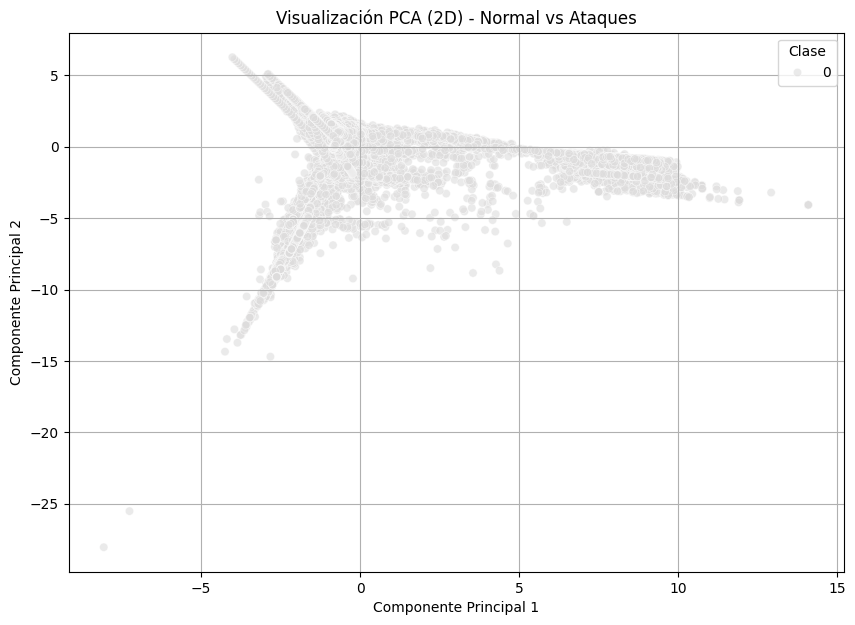

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Asumimos que X_train_preprocesado es tu matriz de características ya normalizada
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocesado)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train2, palette='coolwarm', alpha=0.6)
plt.title("Visualización PCA (2D) - Normal vs Ataques")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clase")
plt.grid(True)
plt.show()

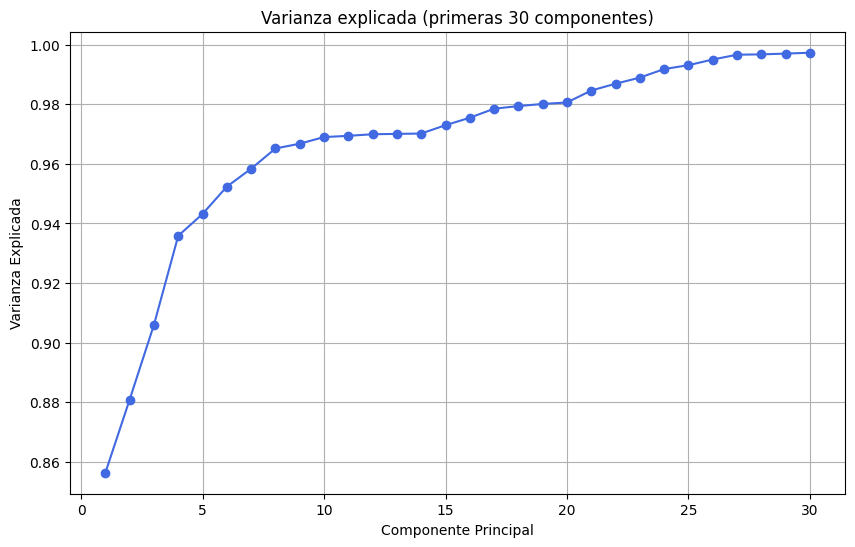

In [65]:
pca = PCA()
pca.fit(X_preprocesado)

k = 30  # podés ajustar este valor
explained_variance = 1-pca.explained_variance_ratio_
components = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(components, explained_variance[:k], marker='o', linestyle='-', color='royalblue')
plt.title(f"Varianza explicada (primeras {k} componentes)")
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada")
plt.grid(True)
plt.show()

C:\Users\ureca\AppData\Local\Temp\ipykernel_22152\2815479245.py:15: UserWarning: Mismatched number of handles and labels: len(handles) = 1 len(labels) = 2
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clase")


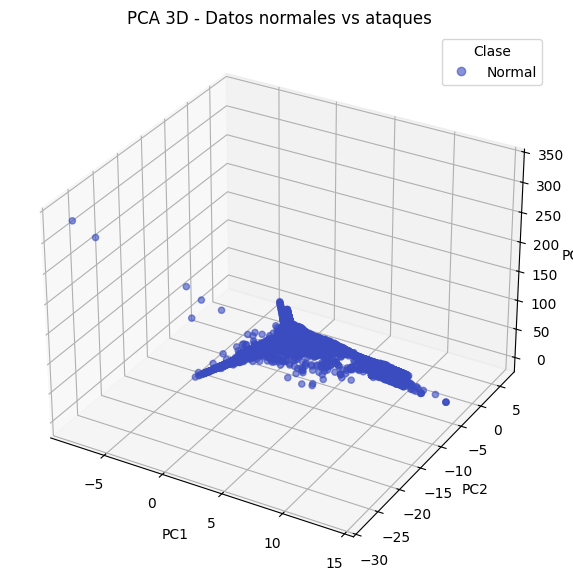

In [253]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicamos PCA a 3D
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_preprocesado)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y_train2, cmap='coolwarm', alpha=0.6)
ax.set_title("PCA 3D - Datos normales vs ataques")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend_labels = ['Normal', 'Ataque']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clase")
plt.show()

### Parte 2

La forma más directa de hacer detección de anomalías utilizando PCA, es mediante el error de reconstrucción. Para esto primero se calculan los componentes principales a partir de los datos de entrenamiento. Luego para cada dato a analizar se lo proyecta sobre estos componentes, y se calcula su reconstrucción. Debido a que los CPs fueron calculado sólo con datos normales, se espera que la reconstrucción de datos anómalos tengan mayores errores. Es por esto que a partir del error de reconstrucción se puede determinar si un dato es anómalo o no.

#### Objetivos:

*   Implementar un detector tal como se describe arriba, utilizando RMSE para calcular el error. El mismo se debe definir como una clase de manera que sea compatible con los *pipelines* de *scikit-learn*. En la siguiente celda se muestra un *template* para crear la clase ([aquí](https://scikit-learn.org/stable/developers/develop.html) se pueden ver otros ejemplos).

*   Crear un *pipeline* que incluya el preprocesamiento y el detector implementado.
*   Entrenar el modelo de manera que mantenga el *99%* de la varianza. 
*   Proponga un punto de operación teniendo en cuenta que se quiere evitar un exceso de falsas alarmas. Para ello se recomienda graficar el compromiso entre *precision* y *recall* para distintos valores de *threshold* que definen el punto de operación. Ver la sección *Precision/Recall Trade-off* del capítulo 3 del libro.
*   Graficar los *scores* de los datos utilizados en el punto anterior, diferenciando con colores los datos normales de los anómalos.
*    Evaluar el desempeño en el conjunto de Validación y Test. Puede resultar útil tener la tasa de aciertos por categoría de anomalía.

In [66]:
# Importo las librerías necesarias
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Defino la clase AD_PCA que hereda de BaseEstimator y OutlierMixin lo que permite que sea compatible con el pipeline.  
# Esta clase debe tener los métodos fit y score. 
class AD_PCA(BaseEstimator, OutlierMixin):
    def __init__(self, n_comp=None):
        '''
        
        Constructor de la clase.

        Parametros:
            n_comp: cantidad de componentes principales a utilizar
            
        '''
        
        self.n_comp = n_comp
    
    def fit(self, X, y=None):
        '''
        
        Se entrena el modelo.

        Parametros:
            X: matriz de datos
            y: etiquetas (no son necesarias)
        
        Retorna:
            self: el objeto
            
        '''

        self.X = X
        self.y = y 
        
        # Agregar código---
        
        self.pca_ = PCA(n_components=self.n_comp)
        self.pca_.fit(X)

        # Guardamos la media para reconstrucción
        #self.mean_ = np.mean(X, axis=0)
        
        #------------------
        
        return self
    
    def score(self, X, y=None):  
        '''
        
        Se calcula el error de reconstrucción de cada muestra. 
        

        Parametros:
            X: matriz de datos
            y: etiquetas (no son necesarias)

        Retorna:
            score: el RMSE de cada muestra reconstruida. 

        '''
        
        # Se verifica que los datos sean válidos
        X = check_array(X)
        
        # Se verifica que el modelo haya sido entrenado
        check_is_fitted(self, ['X', 'y'])

        # Agregar código---
        X_proj = self.pca_.transform(X)
        X_reconstructed = self.pca_.inverse_transform(X_proj)

        # RMSE por muestra
        score = np.sqrt(np.mean((X - X_reconstructed) ** 2, axis=1))


        #------------------
        return score

In [119]:
from sklearn.pipeline import Pipeline

pipeline_pca_99 = Pipeline([
    ('preprocessing', preprocessing_pipeline_default),  
    ('detector', AD_PCA(n_comp=0.99))
])
pipeline_pca_99.fit(X_train)


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocesamiento',
                                  ColumnTransformer(transformers=[('num_imputer',
                                                                   Pipeline(steps=[('imputacion',
                                                                                    SimpleImputer(fill_value=-1,
                                                                                                  strategy='constant')),
                                                                                   ('Scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell'...
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')),
                                                                  ('cat_imputer',
                                                                   Pipeline(steps=[('imputacion',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   Index(['protocol_type', 'service', 'flag', 'land', 'logged_in',
       'is_host_login', 'is_guest_login'],
      dtype='object'))]))])),
                ('detector', AD_PCA(n_comp=0.99))])

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def precision_recall_vs_threshold(y_true, scores, thresholds=np.linspace(0, 100, 100), percentil_linea=95):
    """
    Grafica la curva de precisión y recall a medida que varía el umbral de decisión (en percentiles del score).

    Parámetros:
    - y_true: array-like, etiquetas verdaderas (0 o 1)
    - scores: array-like, scores del modelo (por ejemplo, distancias a centroides en KMeans)
    - thresholds: array-like, lista de percentiles para calcular los umbrales
    - percentil_linea: int, percentil a marcar con línea vertical de referencia

    Retorna:
    - (precisiones, recalls): listas con los valores para cada umbral
    """
    precisiones = []
    recalls = []

    for p in thresholds:
        umbral = np.percentile(scores, p)
        y_pred = (scores > umbral).astype(int)  # 1 = anomalía, 0 = normal

        precisiones.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(15, 6))
    plt.plot(thresholds, precisiones, label='Precisión', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='green')
    plt.axvline(percentil_linea, color='red', linestyle='--', label=f'Ej: umbral={percentil_linea}%')
    plt.xlabel('Umbral (percentil del score)')
    plt.ylabel('Score')
    plt.title('Precisión y Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return precisiones, recalls



In [114]:
rmse_scores = pipeline_pca_99.named_steps['detector'].score(
    pipeline_pca_99.named_steps['preprocessing'].transform(X_val)
)

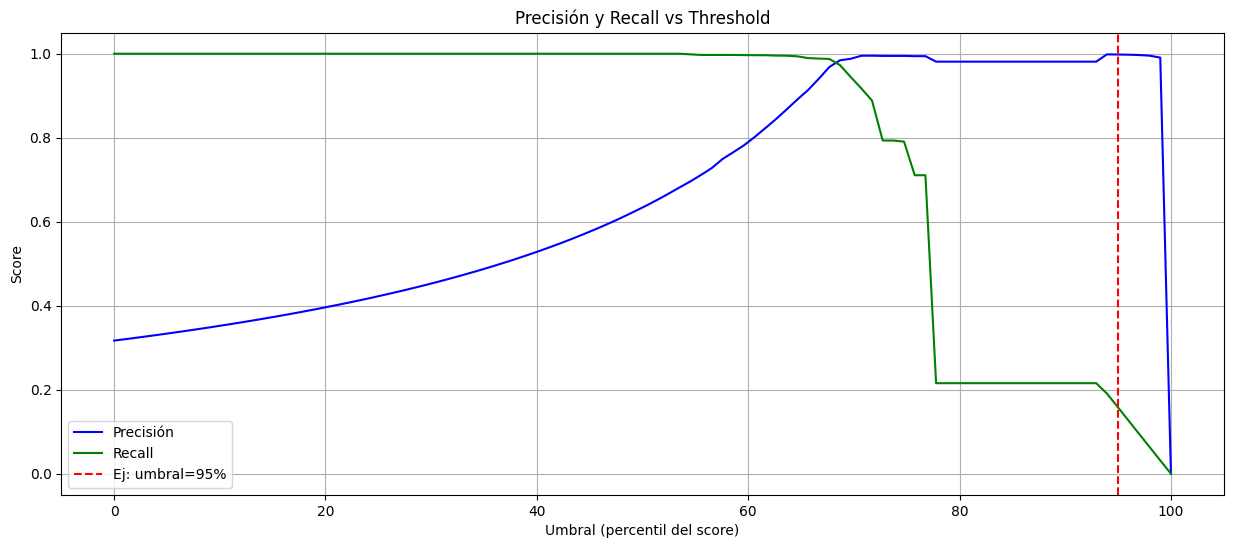

In [115]:
precisiones, recalls = precision_recall_vs_threshold(y_val2, rmse_scores)

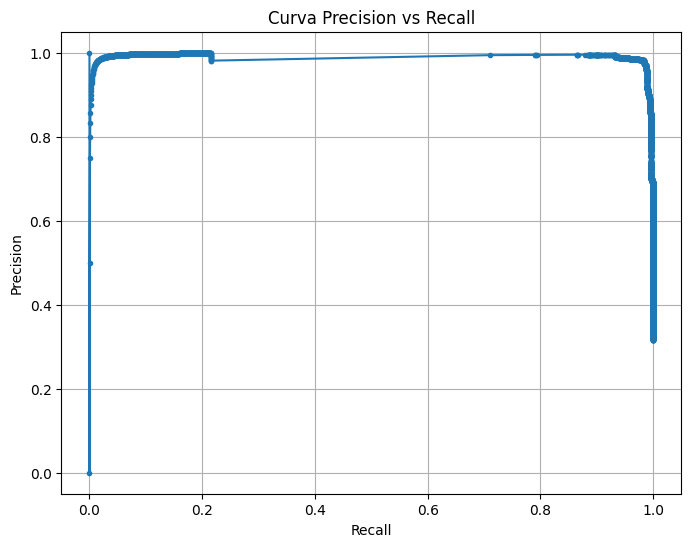

In [120]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val2, rmse_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision vs Recall')
plt.grid(True)
plt.show()

In [16]:
def graficar_scores_con_umbral(y_true, scores, umbral_percentil=95):
    '''
    Función para graficar los scores (RMSE) de los datos y diferenciar entre normales y anómalos.

    Parametros:
        y_true: Etiquetas reales de los datos (0 para normales, 1 para anómalos).
        scores: Los scores de RMSE calculados para cada muestra.
        umbral_percentil: El percentil que define el umbral (ej. 95%).
    '''
    
    # Definimos el umbral en base al percentil de los scores
    umbral = np.percentile(scores, umbral_percentil)
    
    # Etiquetas predichas (normal o anómalo según el umbral)
    predicciones = (scores > umbral).astype(int)
    
    # Creamos una lista de colores para los puntos: verde para normales, rojo para anómalos
    colores = ['green' if label == 0 else 'red' for label in y_true]
    
    # Graficamos los scores
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(scores)), scores, c=colores, alpha=0.6, edgecolors='k')
    
    # Añadimos el umbral
    plt.axhline(umbral, color='black', linestyle='--', label=f'Umbral: {umbral:.2f} (percentil {umbral_percentil}%)')

    # Títulos y etiquetas
    plt.title('Scores de RMSE: Normales vs Anómalos')
    plt.xlabel('Muestras')
    plt.ylabel('Score (RMSE)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return predicciones

In [71]:
def elegir_mejor_umbral(rango_umbral, rmse_scores, y_val2):
    mejores_metricas = None
    mejor_umbral = None
    mejor_promedio = -np.inf  # Inicializamos con un valor muy bajo para buscar el máximo
    
    for umbral in rango_umbral:
        
        predicciones = (rmse_scores > np.percentile(rmse_scores, umbral)).astype(int)
        
        # Generamos el reporte de clasificación
        reporte = classification_report(y_val2, predicciones, target_names=["Normal", "Ataque"], output_dict=True)
        
        # Promediamos precisión y recall de las dos clases
        precision_normal = reporte["Normal"]["precision"]
        recall_normal = reporte["Normal"]["recall"]
        precision_ataque = reporte["Ataque"]["precision"]
        recall_ataque = reporte["Ataque"]["recall"]
        
        # Promedio de precisión y recall
        promedio = (precision_normal + recall_normal + precision_ataque + recall_ataque) / 4
        
        # Si es el mejor promedio hasta ahora, guardamos el umbral y las métricas
        if promedio > mejor_promedio:
            mejor_promedio = promedio
            mejor_umbral = umbral
            mejores_metricas = reporte
    
    return mejor_umbral, mejores_metricas

In [121]:
rango_umbral = range(1, 101)

# Probamos los umbrales con el RMSE calculado previamente
mejor_umbral, mejores_metricas = elegir_mejor_umbral(rango_umbral, rmse_scores, y_val2)

# Imprimimos el mejor umbral y las métricas correspondientes
print(f"Mejor umbral: {mejor_umbral}")
print("Métricas para el mejor umbral:")
print(mejores_metricas)

Mejor umbral: 68
Métricas para el mejor umbral:
{'Normal': {'precision': 0.9925465838509316, 'recall': 0.9880461665292662, 'f1-score': 0.9902912621359223, 'support': 7278.0}, 'Ataque': {'precision': 0.9744868035190616, 'recall': 0.9840094758661534, 'f1-score': 0.9792249889494622, 'support': 3377.0}, 'accuracy': 0.9867667761614266, 'macro avg': {'precision': 0.9835166936849966, 'recall': 0.9860278211977098, 'f1-score': 0.9847581255426923, 'support': 10655.0}, 'weighted avg': {'precision': 0.9868227097842281, 'recall': 0.9867667761614266, 'f1-score': 0.9867839130462296, 'support': 10655.0}}


C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

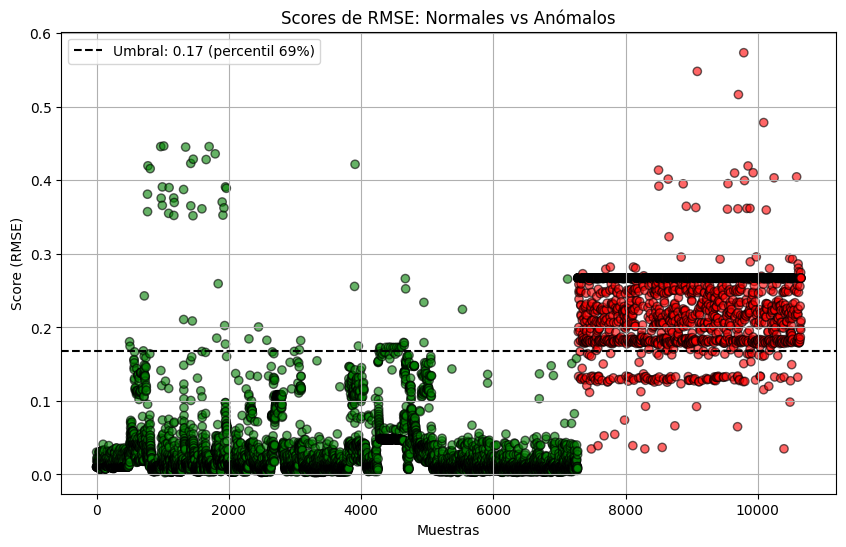

In [73]:
rmse_scores = pipeline_pca_99.named_steps['detector'].score(
    pipeline_pca_99.named_steps['preprocessing'].transform(X_val)
)

# Llamamos a la función para graficar y obtener las predicciones
predicciones = graficar_scores_con_umbral(y_val2, rmse_scores,umbral_percentil=mejor_umbral)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluar desempeño en el conjunto de validación
rmse_scores_val = pipeline_pca_99.named_steps['detector'].score(
    pipeline_pca_99.named_steps['preprocessing'].transform(X_val)
)

# Establecer el umbral para determinar anómalos
umbral = np.percentile(rmse_scores_val, mejor_umbral)
predicciones_val = (rmse_scores_val > umbral).astype(int)

# Ver el reporte de clasificación y la matriz de confusión
print("Matriz de Confusión - Conjunto de Validación:")
print(confusion_matrix(y_val2, predicciones_val))

print("\nReporte de Clasificación - Conjunto de Validación:")
print(classification_report(y_val2, predicciones_val, target_names=["Normal", "Ataque"]))


Matriz de Confusión - Conjunto de Validación:
[[7210   68]
 [ 142 3235]]

Reporte de Clasificación - Conjunto de Validación:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      7278
      Ataque       0.98      0.96      0.97      3377

    accuracy                           0.98     10655
   macro avg       0.98      0.97      0.98     10655
weighted avg       0.98      0.98      0.98     10655



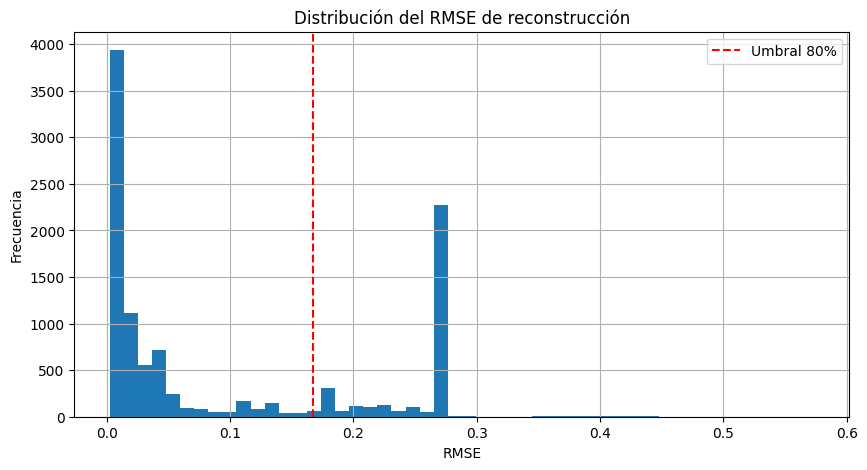

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(rmse_scores, bins=50)
plt.axvline(umbral, color='r', linestyle='--', label='Umbral 80%')
plt.title("Distribución del RMSE de reconstrucción")
plt.xlabel("RMSE")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()

Se otorga una función que, dadas las predicciones, devuelve la tasa de acierto por tipo de anomalía.

In [76]:
def aciertos_por_clase(y, y_pred ,y_g_truth):
    
    '''
    
    Parametros:
        y = Etiquetas del conjunto en Formato 0 o 1
        y_pred = Predicciones en el conjunto en Formato True o False
        y_g_truth = Etiquetas del conjunto en formato string indicando el tipo de anomalía. 
    
    Retorna:
        Devuelve un Dataframe con la tasa de aciertos por Clase.
        
    '''
    y = np.array(y)
    y_pred = np.array(y_pred)
        
    aciertos = ( (y_pred.flatten()*1) == y.flatten())
    type_of_anomaly = list(np.unique(y_g_truth))
    acc_class = []
    
    for i_an in range(len(type_of_anomaly)):
        mask_anomaly  = y_g_truth == type_of_anomaly[i_an] 
        total_tipo = np.count_nonzero(mask_anomaly)
        acc_class.append(np.count_nonzero(aciertos & mask_anomaly)/total_tipo)
        
    return pd.DataFrame([acc_class], columns=type_of_anomaly)

In [79]:
resultados_val = aciertos_por_clase(y_val2, predicciones_val, y_val)
print(resultados_val.T)




                         0
back.             0.066667
buffer_overflow.  0.000000
ipsweep.          1.000000
land.             1.000000
neptune.          0.868597
normal.           0.990657
pod.              1.000000
portsweep.        1.000000
satan.            0.933333
smurf.            1.000000
teardrop.         1.000000
warezclient.      0.000000


In [94]:
rmse_scores_test = pipeline_pca_99.named_steps['detector'].score(
    pipeline_pca_99.named_steps['preprocessing'].transform(X_test)
)

umbral = np.percentile(rmse_scores_test, mejor_umbral)
predicciones_test = (rmse_scores_test > umbral).astype(int)

resultados_test = aciertos_por_clase(y_test2, predicciones_test, y_test)
print(resultados_test.T)

                         0
apache2.          0.630982
back.             0.032787
buffer_overflow.  0.227273
ftp_write.        0.000000
guess_passwd.     0.007786
httptunnel.       0.968354
imap.             1.000000
ipsweep.          0.823529
land.             0.444444
loadmodule.       0.500000
mailbomb.         0.016400
mscan.            0.315290
multihop.         0.055556
named.            0.176471
neptune.          0.010793
nmap.             0.000000
normal.           0.994719
perl.             0.500000
phf.              0.500000
pod.              0.137931
portsweep.        0.542373
processtable.     0.171278
ps.               0.000000
rootkit.          0.153846
saint.            0.805707
satan.            0.790570
sendmail.         0.000000
smurf.            0.348240
snmpgetattack.    0.000000
snmpguess.        0.000000
sqlattack.        0.000000
teardrop.         0.750000
udpstorm.         0.000000
warezmaster.      0.083021
worm.             0.000000
xlock.            0.444444
x

## K-Means

A continuación se implementará un detector de anomalías utilizando el modelo K-Means.

En la *Parte 1*, se llevará a cabo la determinación del número óptimo de clusters necesarios para el problema. En la *Parte 2* se implementará un detector de anomalías.

Para facilitar la construcción del detector, se sugiere implementar un único pipeline que incluya tanto el preprocesamiento como el modelo. 

### Parte 1


#### Ejercicio:

 - Implementar una forma de hallar la cantidad de clusters de K-Means óptima . Se sugiere ver la sección *Finding the optimal number of clusters* del Capítulo 9. 
 
**Comentario**: Emplear alguno de los métodos sugeridos toma un tiempo no menor, se sugiere: (i) economizar las búsquedas, (ii) utilizar semillas, (iii) en cuánto tenga los resultados guardelos en formato *.npy*, *.txt* u otro que considere, para que luego pueda cargar en caso que desee rehacer una gráfica. Seguir esta práctica evita que tenga que volver a correr el experimento.  

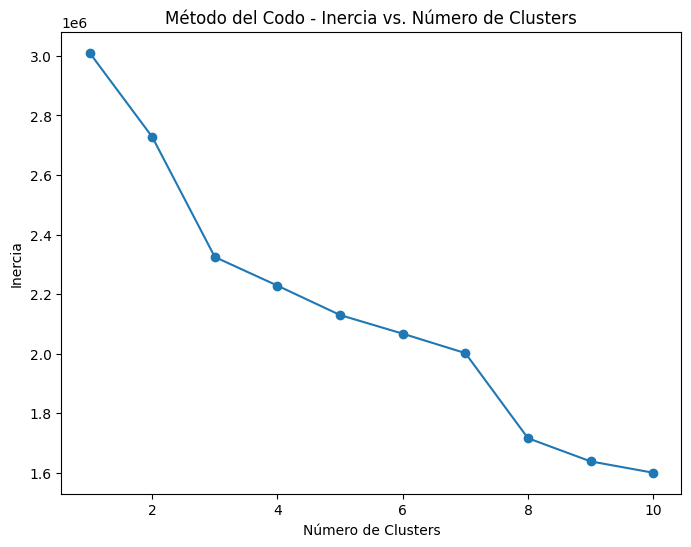

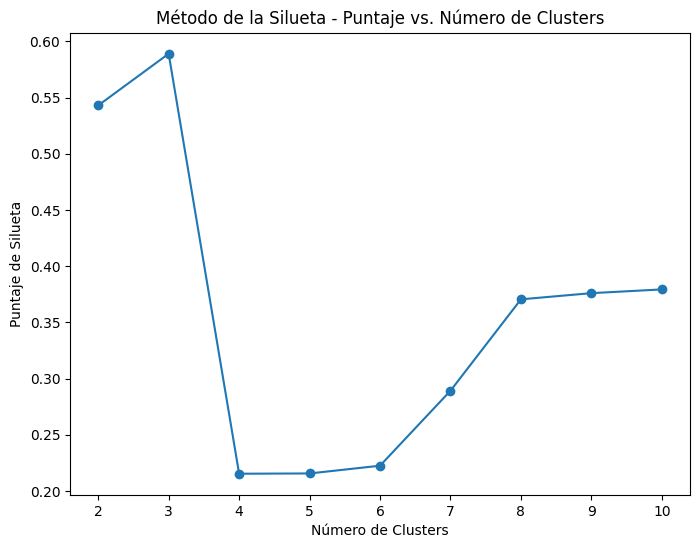

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def metodo_del_codo(X, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Guardamos los resultados
    np.save('inertias.npy', np.array(inertias))
    
    # Graficamos el método del codo
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title("Método del Codo - Inercia vs. Número de Clusters")
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.show()

def metodo_silueta(X, max_clusters=10):
    siluetas = []
    for k in range(2, max_clusters + 1):  # Debe ser al menos 2 clusters para el índice de silueta
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        siluetas.append(silhouette_score(X, kmeans.labels_))
    
    # Guardamos los resultados
    np.save('silhouette_scores.npy', np.array(siluetas))
    
    # Graficamos el método de la silueta
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), siluetas, marker='o')
    plt.title("Método de la Silueta - Puntaje vs. Número de Clusters")
    plt.xlabel("Número de Clusters")
    plt.ylabel("Puntaje de Silueta")
    plt.show()

# Ejecución de los métodos
metodo_del_codo(X_preprocesado)
metodo_silueta(X_preprocesado)

### Parte 2


Una vez seleccionada la cantidad óptima de clusters, se procederá a construir el detector de anomalías utilizando el modelo K-Means. Hay diferentes formas de usar este algoritmo, se sugiere  entrenar el modelo primero y luego calcular la distancia al cluster más cercano. Si esta distancia supera un umbral a definir entonces la muestra se clasificará como anómala.

#### Ejercicios:

- Implementar un detector de anomalías utilizando *K-Means*. Para ello cree una clase y un *pipeline* que lo implemente de forma análoga a lo realizado con el método de PCA.
-   Proponga un punto de operación teniendo en cuenta el compromiso entre *precision* y *recall* para distintos valores de *threshold* que definen el punto de operación. 
-   Graficar los *scores* de los datos utilizados en el punto anterior, diferenciando con colores los datos normales de los anómalos. 
- Evaluar el desempeño en el conjunto de Validación y Test.

In [18]:
# Importo las bibliotecas necesarias
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_array, check_is_fitted


# Defino la clase AD_Kmeans que hereda de BaseEstimator y OutlierMixin lo que permite que sea compatible con el pipeline.
# Esta clase debe tener los métodos fit y score.
class AD_Kmeans(BaseEstimator, OutlierMixin):
    def __init__(self, n_clusters=None):
        '''
        
            Constructor de la clase.

            Parametros:
                n_clusters: cantidad de clusters a utilizar
                
        '''

        self.K = n_clusters
    
    def fit(self, X, y=None):
        '''
            Se entrena el modelo.

            Parametros:
                X: matriz de datos
                y: etiquetas (no son necesarias)

            Retorna:
                self: el objeto
        '''

        self.X = X
        self.y = y 
        
        # Agregar código---
        self.kmeans = KMeans(n_clusters=self.K, random_state=42)
        self.kmeans.fit(X)
        self.centroids_ = self.kmeans.cluster_centers_
        
         #------------------
            
        return self
    
    def score(self, X, y=None):
        '''
        
            Se calcula la distancia mínima de cada muestra a los centroides de los clusters.

            Parámetros:
                X: matriz de datos
                y: etiquetas (no son necesarias)
            
            Retorna:
                d_min: la distancia mínima de cada muestra a los centroides de los clusters.
        
        '''

        # Se verifica que los datos sean válidos
        X = check_array(X)

        # Se verifica que el modelo haya sido entrenado
        check_is_fitted(self, ['X', 'y'])

        # Agregar código---
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids_, axis=2)
        d_min = np.min(dists, axis=1)

        #------------------
    
        return d_min

In [152]:
Mejor_N = 3

detector_kmeans = AD_Kmeans(n_clusters=Mejor_N)

# Pipeline completo: preprocesamiento + detección
full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_default),
    ('detector', detector_kmeans)])


In [153]:
full_pipeline.fit(X_train)

scores_val = full_pipeline.named_steps['detector'].score(
    full_pipeline.named_steps['preprocessing'].transform(X_val)
)
print(scores_val)

[ 3.53997038  3.53997038  7.8402543  ... 35.56055771 35.56055678
 95.38868475]


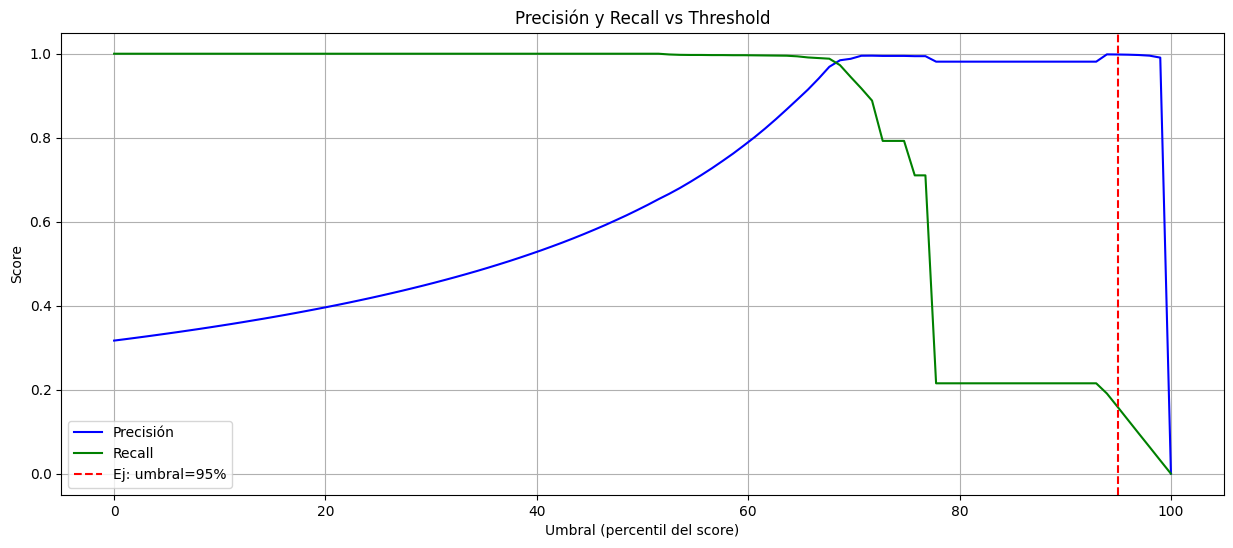

In [141]:
precisiones, recalls = precision_recall_vs_threshold(y_val2, scores_val)

In [212]:
from sklearn.metrics import recall_score
import numpy as np

mejor_recall, mejor_umbral = 0, None
for p in np.linspace(0, 100, 100):
    umbral = np.percentile(scores_val, p)
    y_pred = (scores_val > umbral).astype(int)
    recall = recall_score(y_val2, y_pred)

    
    if recall >= 0.995:
        mejor_recall = recall
        mejor_umbral = p 

print(f"Mejor recall >= 0.995 = {mejor_recall:.4f} en percentil {mejor_umbral:.1f}")


Mejor recall >= 0.995 = 0.9953 en percentil 63.6


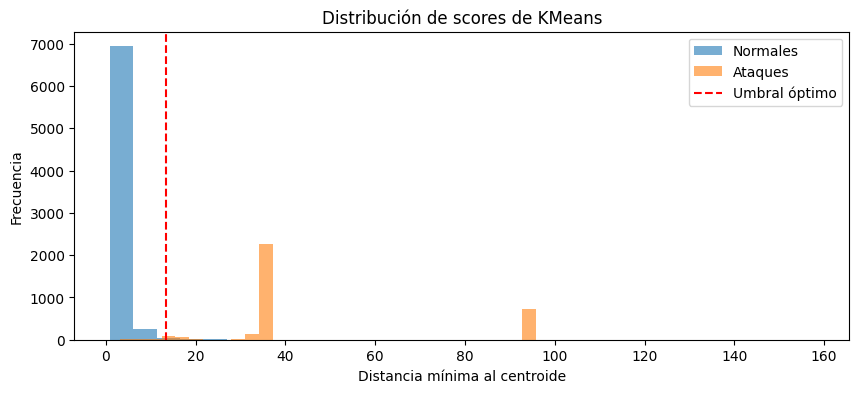

In [201]:
plt.figure(figsize=(10, 4))
plt.hist(scores_val[y_val2 == 0], bins=30, alpha=0.6, label='Normales')
plt.hist(scores_val[y_val2 == 1], bins=30, alpha=0.6, label='Ataques')
plt.axvline(best_threshold, color='red', linestyle='--', label='Umbral óptimo')
plt.title("Distribución de scores de KMeans")
plt.xlabel("Distancia mínima al centroide")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [205]:
full_pipeline.fit(X_train)

X_test_proc = full_pipeline.named_steps['preprocessing'].transform(X_test)
scores_test = full_pipeline.named_steps['detector'].score(X_test_proc)

umbral = np.percentile(scores_val, mejor_umbral)

preds_test = (scores_test > umbral).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test2, preds_test, target_names=["Normal", "Ataque"]))

              precision    recall  f1-score   support

      Normal       0.74      0.94      0.83     60593
      Ataque       0.98      0.92      0.95    250436

    accuracy                           0.92    311029
   macro avg       0.86      0.93      0.89    311029
weighted avg       0.94      0.92      0.93    311029



In [206]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test2, preds_test))

[[ 57008   3585]
 [ 19759 230677]]


In [207]:
resultados_test = aciertos_por_clase(y_test2, preds_test, y_test)
print(resultados_test.T)


                         0
apache2.          0.997481
back.             0.040984
buffer_overflow.  1.000000
ftp_write.        0.666667
guess_passwd.     0.177925
httptunnel.       0.974684
imap.             1.000000
ipsweep.          0.990196
land.             1.000000
loadmodule.       1.000000
mailbomb.         0.082400
mscan.            0.994302
multihop.         0.500000
named.            0.882353
neptune.          1.000000
nmap.             1.000000
normal.           0.940835
perl.             1.000000
phf.              1.000000
pod.              0.988506
portsweep.        1.000000
processtable.     1.000000
ps.               0.812500
rootkit.          0.769231
saint.            0.995924
satan.            0.998775
sendmail.         0.941176
smurf.            0.999537
snmpgetattack.    0.005555
snmpguess.        0.004156
sqlattack.        1.000000
teardrop.         0.833333
udpstorm.         1.000000
warezmaster.      0.805243
worm.             0.000000
xlock.            0.888889
x

In [208]:
resultados_dict = resultados_test.iloc[0].to_dict()

clases_val = np.unique(y_val)
clases_en_val = set(clases_val)
clases_en_test = set(resultados_dict.keys())

aciertos_en_val = []
aciertos_no_val = []

for clase, score in resultados_dict.items():
    if clase in clases_en_val:
        aciertos_en_val.append(score)
    else:
        aciertos_no_val.append(score)


In [209]:
print("Promedio acierto para clases en validación:", np.mean(aciertos_en_val))
print("Promedio acierto para clases NO vistas en validación:", np.mean(aciertos_no_val))


Promedio acierto para clases en validación: 0.8901968743596523
Promedio acierto para clases NO vistas en validación: 0.7499439335284622


In [210]:
aciertos_de_val = {clase: acc for clase, acc in resultados_dict.items() if clase in clases_en_val}
for clase, acc in aciertos_de_val.items():
    print(f"{clase}: {acc:.3f}")

back.: 0.041
buffer_overflow.: 1.000
ipsweep.: 0.990
land.: 1.000
neptune.: 1.000
normal.: 0.941
pod.: 0.989
portsweep.: 1.000
satan.: 0.999
smurf.: 1.000
teardrop.: 0.833


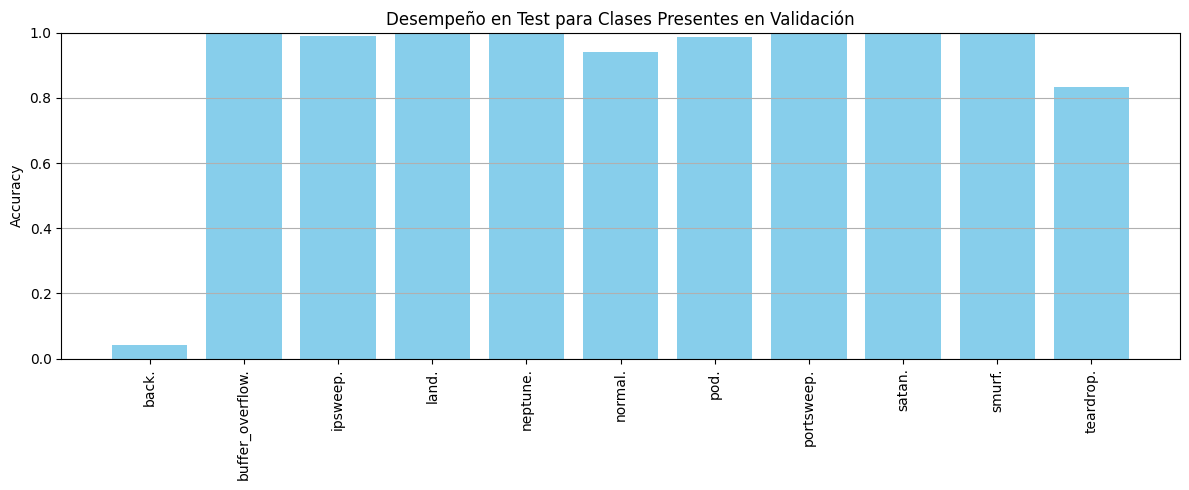

In [211]:
import matplotlib.pyplot as plt

clases = list(aciertos_de_val.keys())
scores = list(aciertos_de_val.values())

plt.figure(figsize=(12, 5))
plt.bar(clases, scores, color='skyblue')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title('Desempeño en Test para Clases Presentes en Validación')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Gaussian Mixtures Models

Por último, se implementará un detector de anomalías utilizando el modelo mezcla de gaussianas (GMM).

En la *Parte 1*, se llevará a cabo la determinación del número óptimo de clusters necesarios para el problema. Una vez seleccionado el número adecuado de clusters, se procederá a la construcción del clasificador en la *Parte 2*.

Nuevamente, para facilitar la construcción del detector, se sugiere implementar un único pipeline que incluya tanto el preprocesamiento como el modelo.

### Parte 1


Siga el ejemplo de la sección *Anomaly Detection Using Gaussian Mixture* en el Capítulo 9 del libro, y determine la cantidad óptima de mezclas a utilizar por el modelo.


#### Ejercicio:

 - Proponer una forma de hallar la cantidad óptima de mezclas a utilizar.
 
 **Comentario**: Emplear alguno de los métodos sugeridos toma un tiempo no menor, se sugiere: (i) economizar las búsquedas, (ii) utilizar semillas, (iii) en cuánto tenga los resultados guardelos en formato *.npy*, *.txt* u otro que considere, para que luego pueda cargar en caso que desee rehacer una gráfica. Seguir esta práctica evita que tenga que volver a correr el experimento.  

In [157]:
X_solo_preprocesado = preprocessing_pipeline_default.fit_transform(X_train)

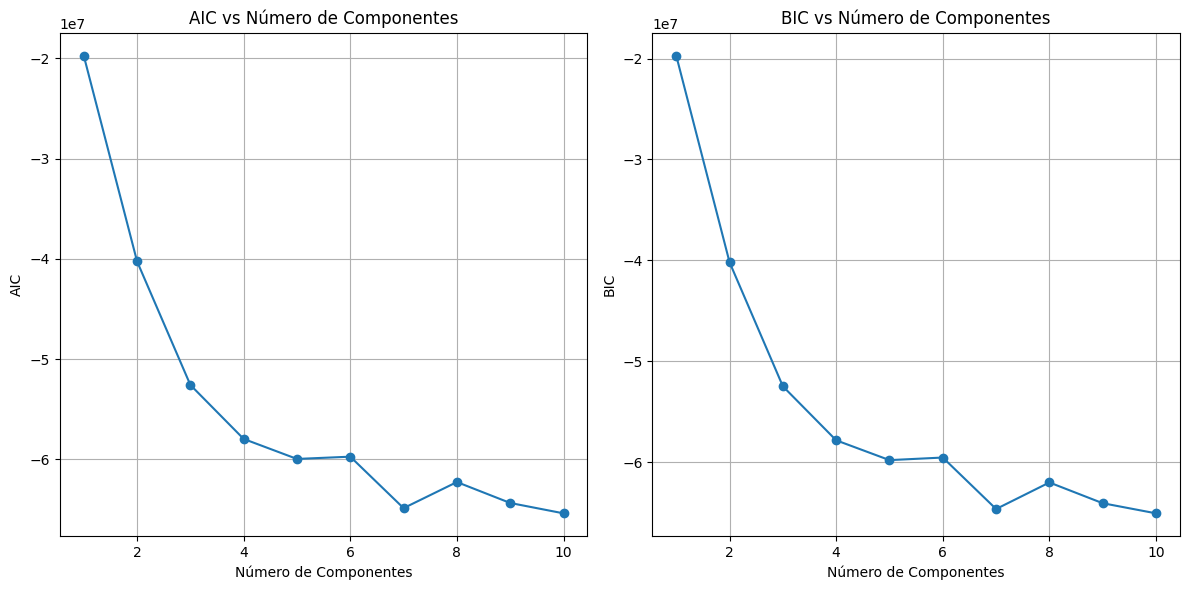

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import joblib  # Para guardar los resultados
component_range = range(1, 11)

# Lista para almacenar los valores de AIC y BIC
aic_scores = []
bic_scores = []

# Definir la semilla para reproducibilidad
seed = 42

# Entrenar el modelo para diferentes números de componentes
for n_comp in component_range:
    gmm = GaussianMixture(n_components=n_comp, random_state=seed)
    gmm.fit(X_solo_preprocesado)  # Asegúrate de que X_train esté preprocesado si es necesario
    
    aic_scores.append(gmm.aic(X_solo_preprocesado))  # Calcular AIC
    bic_scores.append(gmm.bic(X_solo_preprocesado))  # Calcular BIC

# Guardar los resultados en archivos
np.save("aic_scores.npy", np.array(aic_scores))
np.save("bic_scores.npy", np.array(bic_scores))

# Graficar los resultados de AIC y BIC
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(component_range, aic_scores, label="AIC", marker='o')
plt.title('AIC vs Número de Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('AIC')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(component_range, bic_scores, label="BIC", marker='o')
plt.title('BIC vs Número de Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('BIC')
plt.grid(True)

plt.tight_layout()
plt.show()

In [168]:
N=5


### Parte 2

Siguiendo también el el ejemplo de la sección *Anomaly Detection Using Gaussian Mixture* en el Capítulo 9 del libro, construya y entrene un clasificador de anomalías utilizando la cantidad de mezclas determinadas en la parte anterior. 

Una vez entrenado el modelo, se calcula la log-verosimilitud de cada muestra y se umbraliza para detectar anomalías. Si el valor de la log-verosimilitud es menor que un umbral determinado, se considera que la muestra es anómala.

El valor del umbral se fija a partir de determinar la proporción de muestras que se clasifican como anómalas. Por ejemplo, si se sabe de antemano que los ataques constituyen un porcentaje $\alpha$ de las muestras, se puede calcular el valor que define el percentil correspondiente a este $\alpha$% en la escala de log-verosimilitud para clasificar las muestras como anómalas.


#### Ejercicios:

*   Implementar un detector que calcule el valor de los *scores*, la log-verosimilitud en este caso. En la siguiente celda se proporciona un *template* para la implementación del detector.
*   Fijar un umbral en validación utilizando algún percentil similar a lo realizado en el Capítulo 9 del libro. Se obtendrán distintos puntos de funcionamiento en función del percentil elegido. Discutir sobre los resultados obtenidos.
*   Evaluar el desempeño en el conjunto de Validación y Test. 

In [236]:
# Importo las bibliotecas necesarias
from sklearn.mixture import GaussianMixture
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.utils.validation import check_array, check_is_fitted

# Defino la clase AD_GMM que hereda de BaseEstimator y OutlierMixin lo que permite que sea compatible con el pipeline.
# Esta clase debe tener los métodos fit y score.
class AD_GMM(BaseEstimator, OutlierMixin):
    def __init__(self, n_comp=None):
        '''
        
            Constructor de la clase.

            Parametros:
                n_comp: cantidad de componentes principales a utilizar
                
        '''

        self.n_comp = n_comp
    
    def fit(self, X, y=None):
        '''
        
            Se entrena el modelo.

            Parametros:
                X: matriz de datos
                y: etiquetas (no son necesarias)

            Retorna:
                self: el objeto

        '''

        self.classes_ = [1, 0]
        self.X = X
        self.y = y 
        
        # Agregar código---
        self.gmm = GaussianMixture(n_components=self.n_comp)
        self.gmm.fit(X)
 
        
        #------------
        return self
    
    def score(self, X, y=None):
        '''
        
            Se calcula la log-verosimilitud de cada muestra.
            
            Parametros:
                X: matriz de datos
                y: etiquetas (no son necesarias)
            
            Retorna:
                score: el score de cada muestra.
                
        '''

        # Se verifica que los datos sean válidos
        X = check_array(X)

        # Se verifica que el modelo haya sido entrenado
        check_is_fitted(self, ['X', 'y'])

        # Agregar código---
        log_likelihood = self.gmm.score_samples(X)
        
        return log_likelihood

        
        #------------------
        
        return score

In [237]:
pipeline_gmm = Pipeline([
    ('preprocessing', preprocessing_pipeline_default),
    ('gmm', AD_GMM(n_comp=N))  
])
pipeline_gmm.fit(X_train)

# Obtener la log-verosimilitud en el conjunto de validación
log_likelihood_val = pipeline_gmm.named_steps['gmm'].score(pipeline_gmm.named_steps['preprocessing'].transform(X_val))

# Establecer el umbral usando un percentil
percentil = 0.4
umbral = np.percentile(log_likelihood_val, percentil)

# Clasificar las muestras como normales (0) o anómalas (1)
predicciones_val = (log_likelihood_val < umbral).astype(int)

# Evaluar el desempeño en el conjunto de validación
from sklearn.metrics import classification_report, confusion_matrix
print(f"Evaluación con umbral en el percentil {percentil}:")
print(confusion_matrix(y_val2, predicciones_val))  # Matriz de confusión
print(classification_report(y_val2, predicciones_val))  # Reporte de clasificación

Evaluación con umbral en el percentil 0.4:
[[7278    0]
 [3334   43]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.81      7278
           1       1.00      0.01      0.03      3377

    accuracy                           0.69     10655
   macro avg       0.84      0.51      0.42     10655
weighted avg       0.79      0.69      0.56     10655



C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\m

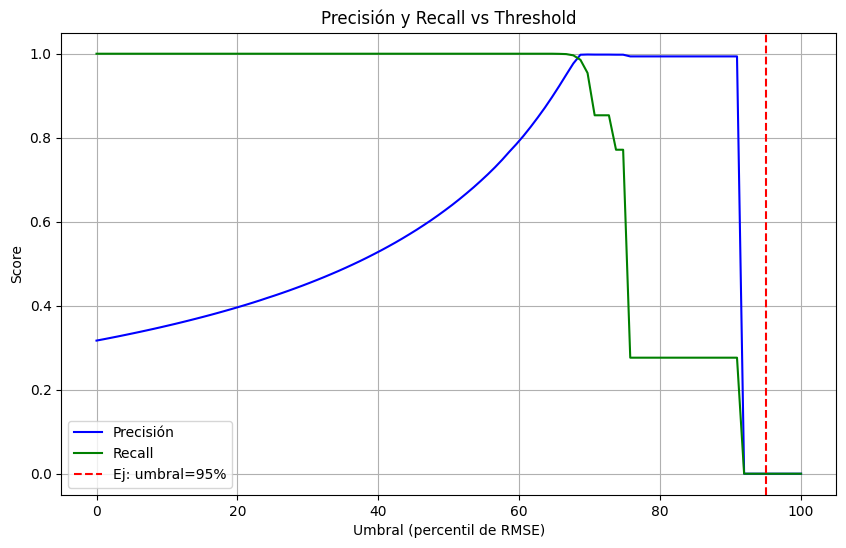

In [238]:

precisiones, recalls = precision_recall_vs_threshold(y_val2, -np.exp(log_likelihood_val))

In [239]:
rango_umbral = range(1, 101)

# Probamos los umbrales con el RMSE calculado previamente
mejor_umbral, mejores_metricas = elegir_mejor_umbral(rango_umbral, -np.exp(log_likelihood_val), y_val2)

# Imprimimos el mejor umbral y las métricas correspondientes
print(f"Mejor umbral: {mejor_umbral}")
print("Métricas para el mejor umbral:")
print(mejores_metricas)

Mejor umbral: 68
Métricas para el mejor umbral:
{'Normal': {'precision': 0.9969634230503795, 'recall': 0.9924429788403407, 'f1-score': 0.9946980651380569, 'support': 7278.0}, 'Ataque': {'precision': 0.9838709677419355, 'recall': 0.993485342019544, 'f1-score': 0.9886547811993517, 'support': 3377.0}, 'accuracy': 0.9927733458470201, 'macro avg': {'precision': 0.9904171953961576, 'recall': 0.9929641604299424, 'f1-score': 0.9916764231687043, 'support': 10655.0}, 'weighted avg': {'precision': 0.9928138949812462, 'recall': 0.9927733458470201, 'f1-score': 0.9927827042876572, 'support': 10655.0}}


C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

# Opcional

*   Aplicar a los datos del problema alguno de los detectores de *sikit-learn* como: One-Class SVM, Isolation Forest
*   Realizar ingeniería de características.
*   Combinar PCA con K-Means y/o GMM


In [232]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score

pipeline_combinacion = Pipeline([
    ('preprocessing', preprocessing_pipeline_default), 
    ('isolation_forest', IsolationForest(n_estimators=100, contamination=0.2)),
     
])

pipeline_combinacion.fit(X_train,y_train2)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocesamiento',
                                  ColumnTransformer(transformers=[('num_imputer',
                                                                   Pipeline(steps=[('imputacion',
                                                                                    SimpleImputer(fill_value=-1,
                                                                                                  strategy='constant')),
                                                                                   ('Scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell'...
       'dst_host_srv_rerror_rate'],
      dtype='object')),
                                                                  ('cat_imputer',
                                                                   Pipeline(steps=[('imputacion',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   Index(['protocol_type', 'service', 'flag', 'land', 'logged_in',
       'is_host_login', 'is_guest_login'],
      dtype='object'))]))])),
                ('isolation_forest', IsolationForest(contamination=0.2))])

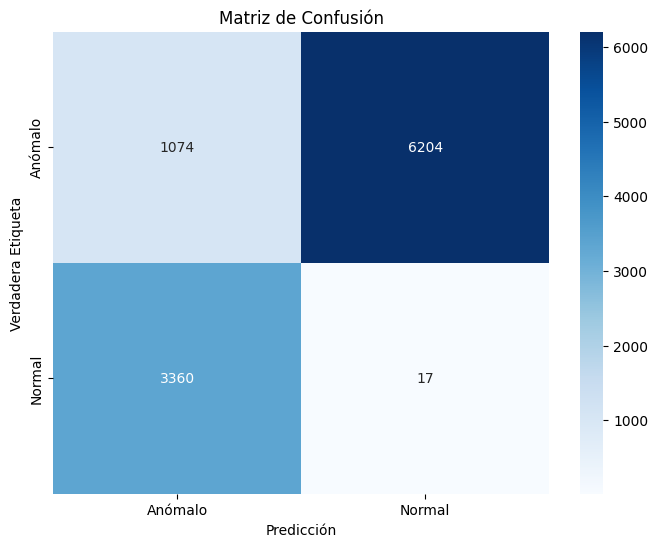

In [233]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
# Predicciones en el conjunto de test
predicciones = pipeline_combinacion.predict(X_val)
predicciones = (predicciones == 1).astype(int)

# Graficar los resultados, por ejemplo, la matriz de confusión
# Matriz de confusión
cm = confusion_matrix(y_val2, predicciones)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Anómalo", "Normal"], yticklabels=["Anómalo", "Normal"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadera Etiqueta")
plt.show()

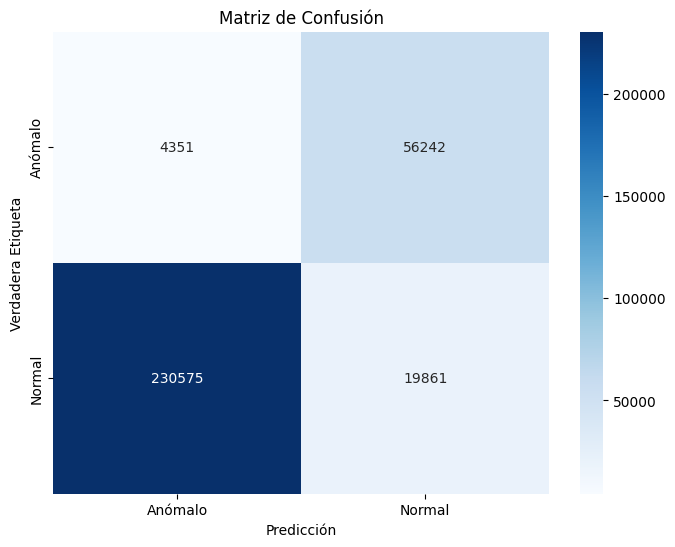

In [234]:
predicciones_test = pipeline_combinacion.predict(X_test)
predicciones_test = (predicciones_test == 1).astype(int)
cm = confusion_matrix(y_test2, predicciones_test)
cm = cm.astype(int)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Anómalo", "Normal"], yticklabels=["Anómalo", "Normal"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadera Etiqueta")
plt.show()

In [235]:
print(accuracy_score(y_test2,predicciones_test))

0.07784483118937463
